# Collaborative filtering explained using Amazon Reviews dataset

In [27]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.sparse import csc_matrix
from sklearn.metrics.pairwise import cosine_similarity
import sqlite3
import numpy as np
import seaborn as sns; sns.set(style="white", color_codes=True)
import warnings 
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')


In [4]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')
df.rename(columns={'unixReviewTime': 'ReviewTime', 'asin': 'product'}, inplace=True)
df.drop('reviewTime',1)
df.head()

,reviewerID,product,reviewerName,helpful,ReviewTime,reviewText,overall,reviewTime,summary
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",2013-06-01,Just another flavor of Kit Kat but the taste i...,4.0,"06 1, 2013",Good Taste
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",2014-05-19,I bought this on impulse and it comes from Jap...,3.0,"05 19, 2014","3.5 stars, sadly not as wonderful as I had hoped"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",2013-10-08,Really good. Great gift for any fan of green t...,4.0,"10 8, 2013",Yum!
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]",2013-05-20,"I had never had it before, was curious to see ...",5.0,"05 20, 2013",Unexpected flavor meld
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",2013-05-26,I've been looking forward to trying these afte...,4.0,"05 26, 2013","Not a very strong tea flavor, but still yummy ..."


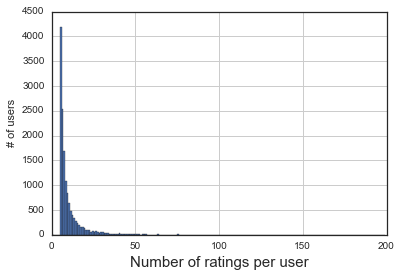

In [6]:
d = df.groupby(['reviewerID'])
ax = d['product'].count().hist(bins=xrange(0, 200, 1))
plt.xlabel('Number of ratings per user', size=15)
plt.ylabel('# of users');

In [28]:
number_of_unique_users = len(df['product'].unique())
number_of_unique_products = len(df['reviewerID'].unique())
number_of_ratings = len(df)
print "Number of unique products =", number_of_unique_products
print "Number of unique users =", number_of_unique_users
print "Number of ratings =", number_of_ratings

Number of unique products = 14681
Number of unique users = 8713
Number of ratings = 151254


Mean rating = 4.24304150634


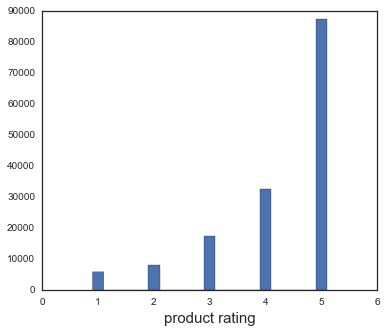

In [10]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.hist(df['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('product rating', fontsize=15)

mean_rating = df['overall'].mean()
print "Mean rating =", mean_rating

Looks like the distribution is highly skewed towards very positive reviews, which is a well known effect with ratings - unless the customer is highly dissatisfied with a product they will give it a "5".

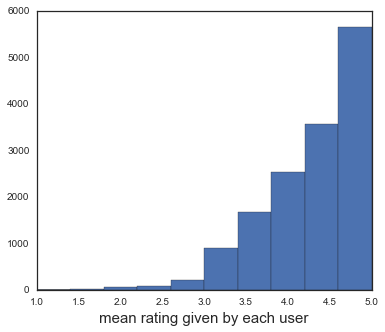

In [11]:
# mean ratings from each user
mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each user', fontsize=15)

In [12]:
test_data = df.groupby('reviewerID', as_index=False).apply(lambda x: x.loc[np.random.choice(x.index, 1, replace=False),:])

In [13]:
l1 = [x[1] for x in test_data.index.tolist()]


In [14]:
train_data = df.drop(df.index[l1]).dropna()

In [15]:
train_data['reviewerID'] = train_data['reviewerID'].astype("category")
train_data['product'] = train_data['product'].astype("category")

In [18]:
print "Unique users: %s" % (len(train_data['reviewerID'].unique()))
print "Unique products: %s" % (len(train_data['product'].unique()))
 
# create a sparse matrix of all the artist/user/play triples
reviews_matrix = csc_matrix((train_data['overall'].astype(float), 
                   (train_data['product'].cat.codes, 
                    train_data['reviewerID'].cat.codes)))  

Unique users: 14678
Unique products: 8711


# Most basic recommendation: mean rating [benchmark]

In order to see how good our recommendations are we first need to have a benchmark to which we can compare their results. Comparing it against zero would not be appropriate here, since it is not the most common rating as we saw in the histogram above. The most common rating would be the median, which in the case of this particular dataset is different from the mean:


In [23]:
mean_rating_train = train_data['overall'].mean()
median_rating_train = train_data['overall'].median()
print "Mean rating =", mean_rating_
print "Median rating =", median_rating_

Mean rating = 4.24258311642
Median rating = 5.0


The distribution of ratings is highly skewed to the right. Most users when asked to rate the item give it the maximum rating, which is an interesting psychological phenomenon. Apparently, maximum rating is the baseline from which users diverge only when there is something clearly wrong with the product. Taking this into account when relying on statistics which require a normal distribution is essential. For this reason, when designing a survey, one might choose to scale the possible range of responses such that the baseline is 0 by asking participants to give an answer from -2 (negative feedback) to 2 (positive feedback). But this is not the place to elaborate on that. If interested, read more about the issues around Likert scale in psychometrics:-).

In [31]:
rmse_benchmark = np.sqrt(pow(train_data['overall']-mean_rating_train, 2).mean())
print "Root-mean-square error = {:4.2f}".format(rmse_benchmark)

Root-mean-square error = 1.09


Let's see how the RMSE changes when we use the median instead of the mean:

In [30]:
rmse_benchmark_median = np.sqrt(pow(train_data['overall']-median_rating_train, 2).mean())
print "Root-mean-square error for median = {:4.2f}".format(rmse_benchmark_median)

Root-mean-square error for median = 1.32


It's actually bigger, so let's stick to the mean.

In [25]:
# Calculate the similarity score between users
user_user_similarity = cosine_similarity(reviews_matrix)
user_user_similarity.shape

(8711, 8711)

In [26]:
sqdiffs = 0
num_preds = 0
cnt_no_other_ratings = 0

# for each user
for user_i, non_zero_entries in enumerate(reviews_matrix):

    for product in non_zero_entries.indices:
        
        # all users that have rated imovie (includes user of interest)
        i_has_rated = reviews_matrix[:,product].indices
        
        # remove the current user 
        iremove = np.argmin(abs(i_has_rated - user_i)) 
        i_others_have_rated = np.delete(i_has_rated, iremove)
        
        try:
            # find most similar user that has also rated imovie to current user
            i_most_sim = np.argmax(user_user_similarity[user_i, i_others_have_rated])
        except:
            cnt_no_other_ratings += 1
            continue
        
        # prediction error
        predicted_rating = reviews_matrix[i_others_have_rated[i_most_sim], product]
        
        actual_rating = reviews_matrix[user_i, product]
        
        sqdiffs += pow(predicted_rating-actual_rating, 2.)
        num_preds += 1
        
rmse_cossim = np.sqrt(sqdiffs/num_preds)   

print "Failed to predict ", cnt_no_other_ratings, " ratings"
print "Mean square error from cosine similarity is ", str(rmse_cossim)
print "Benchmark is ", str(rmse_benchmark)

Failed to predict  3  ratings
Mean square error from cosine similarity is  1.22923937415
Benchmark is  1.32490601422


# Weighted mean 

In [53]:
sqdiffs = 0
num_preds = 0

# to protect against divide by zero issues
eps = 1e-6

cnt_no_sims = 0

# for each user
for user_i, non_zero_entries in enumerate(reviews_matrix):
    
    # for each rated movie: find users who HAVE ALSO rated this movie
    for product in non_zero_entries.indices:
                
        # all users that have rated imovie (includes user of interest)
        i_has_rated = reviews_matrix[:,product].indices
        
        # remove the current user 
        #print i_has_rated, user_i
        iremove = np.argmin(abs(i_has_rated - user_i)) 
        i_others_have_rated = np.delete(i_has_rated, iremove)
        
        
        # rating is weighted sum of all ratings, weights are cosine sims
        ratings = reviews_matrix[i_others_have_rated, product]
        sims = user_user_similarity[user_i, i_others_have_rated]
        
        
        norm = np.sum(sims)
        if norm==0:
            cnt_no_sims += 1
            norm = eps
        
        predicted_rating = np.sum(np.multiply(ratings.A.T, sims))/norm
        
        # prediction error
        actual_rating = reviews_matrix[user_i, product]
        
        sqdiffs += pow(predicted_rating-actual_rating, 2.)
        num_preds += 1
        

rmse_cossim = np.sqrt(sqdiffs/num_preds)

print cnt_no_sims, "movies had only one user rating" 
print "Number of predictions made =", num_preds
print "Mean root mean square error =", rmse_cossim

3 movies had only one user rating
Number of predictions made = 135232
Root mean square error = 1.03182360221


Great! Our predictions have improved. Another improvement we could introduce is to take into account only *n* most similar users - then our predictions should be more accurate. This will improve our predictions only for products which have a variety of users rating them (so some of them will be similar to each other, and some will not). On average, however, our predictions should improve.

In [110]:
def rmse_topN(topN):
    """Return the root-mean-square-error given value topN
       for using the 'top N' most similar users in predicting
       the rating
    """
    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # for each user
    for user_i, non_zero_entries in enumerate(reviews_matrix):

        # for each rated movie: find users who HAVE ALSO rated this movie
        for product in non_zero_entries.indices:

            # all users that have rated imovie (includes user of interest)
            i_has_rated = reviews_matrix[:,product].indices

            # remove the current user 
            #print i_has_rated, user_i
            iremove = np.argmin(abs(i_has_rated - user_i)) 
            i_others_have_rated = np.delete(i_has_rated, iremove)


            # rating is weighted sum of all ratings, weights are cosine sims
            ratings = reviews_matrix[i_others_have_rated, product].A
            sims = user_user_similarity[user_i, i_others_have_rated]
            
            #choose top N most similar users
            most_similar_users = sims[np.argsort(sims*-1)][:topN]
            most_similar_ratings = ratings[np.argsort(sims*-1)][:topN]


            norm = np.sum(most_similar_users)
            if norm==0:
                cnt_no_sims += 1
                norm = eps

            predicted_rating = np.sum(np.multiply(most_similar_ratings.T, most_similar_users))/norm

            # prediction error
            actual_rating = reviews_matrix[user_i, product]

            sqdiffs += pow(predicted_rating-actual_rating, 2.)
            num_preds += 1


    rmse_cossim = np.sqrt(sqdiffs/num_preds)
    
    print "Using top", topN , "most similar users to predict rating"
    print "Number of predictions made =", num_preds
    print "Root mean square error =", rmse_cossim , '\n'
    return rmse_cossim



In [112]:
topN_trials = [2, 5, 10, 20, 30, 50]
rmse_results = []
for topN in topN_trials:
    rmse_results.append(rmse_topN(topN))

Using top 2 most similar users to predict rating
Number of predictions made = 135232
Root mean square error = 1.12168067488 

Using top 5 most similar users to predict rating
Number of predictions made = 135232
Root mean square error = 1.0567853148 

Using top 10 most similar users to predict rating
Number of predictions made = 135232
Root mean square error = 1.03886793899 

Using top 20 most similar users to predict rating
Number of predictions made = 135232
Root mean square error = 1.03366155368 

Using top 30 most similar users to predict rating
Number of predictions made = 135232
Root mean square error = 1.03256664708 

Using top 50 most similar users to predict rating
Number of predictions made = 135232
Root mean square error = 1.03220140086 



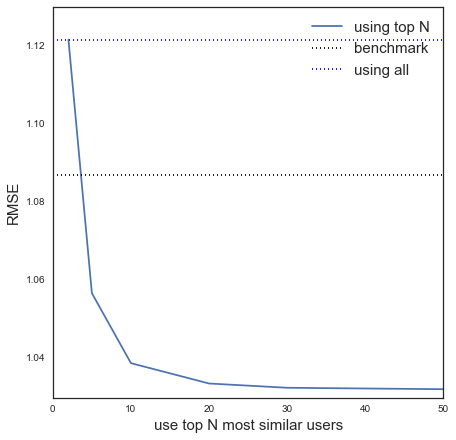

In [115]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(topN_trials, rmse_results, label='using top N')
xlims = ax.get_xlim()
ax.plot(xlims, [rmse_benchmark, rmse_benchmark], color='black', 
        linestyle='dotted', label='benchmark')
ax.plot(xlims, [rmse_cossim, rmse_cossim], color='blue', linestyle='dotted',
        label='using all')

ax.set_xlabel('use top N most similar users', fontsize=15)
ax.set_ylabel('RMSE', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=15)